In [1]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


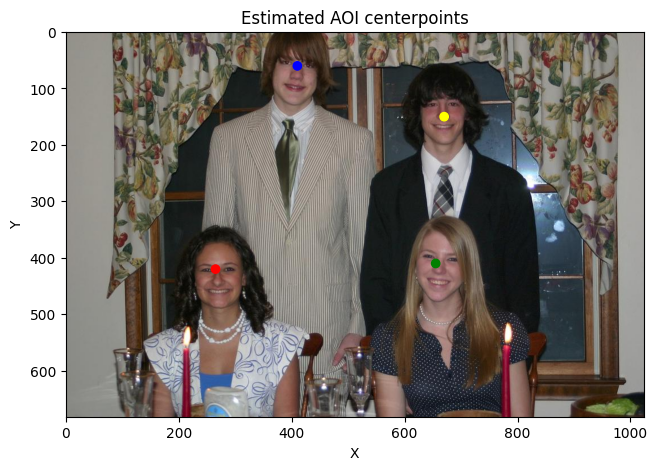

In [44]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import networkx as nx
from graphutils import GraphUtils

import math
# 14, 17, 29, 38, 56!!!
dataset_index = 56
img_path = f"../TrainingDataset/TrainingData/Images/{dataset_index}.png"
td_data_path = f"../TrainingDataset/TrainingData/TD/TD_scanpath_{dataset_index}.txt"
asd_data_path = f"../TrainingDataset/TrainingData/ASD/ASD_scanpath_{dataset_index}.txt"
td_data = pd.read_csv(td_data_path, usecols=[0, 1, 2, 3])
asd_data = pd.read_csv(asd_data_path, usecols=[0, 1, 2, 3])
td_data.columns = ["idx", "x", "y", "t"]
asd_data.columns = ["idx", "x", "y", "t"]

td_data["subject"] = (td_data['idx'] == 0).cumsum()
groups = [g for _, g in td_data.groupby('subject')]
td_dfs = [group.reset_index(drop=True) for _, group in td_data.groupby('subject')]

asd_data["subject"] = (asd_data['idx'] == 0).cumsum()
groups = [g for _, g in asd_data.groupby('subject')]
asd_dfs = [group.reset_index(drop=True) for _, group in asd_data.groupby('subject')]


AOIS = pd.DataFrame(
    {
        "x": np.array([410, 265, 655, 670], dtype=float),
        "y": np.array([60, 420, 410, 150], dtype=float),
        "color": ["blue", "red", "green", "yellow"],
    }
)

def get_closest_aoi(aois: pd.DataFrame, data: pd.DataFrame) -> None:
    distance_cols = []
    for aoi in range(len(aois)):
        distance_cols.append(f"distance_{aoi}")

        data[f"distance_{aoi}"] = np.linalg.norm(
            data[["x", "y"]].values - np.array([aois.loc[aoi, "x"], aois.loc[aoi, "y"]]), axis=1
        )

    data["AOI"] = data[distance_cols].idxmin(axis=1).str.replace("distance_", "").astype(int)
    

image = Image.open(img_path)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(AOIS["x"], AOIS["y"], color=AOIS["color"])
ax.set(title="Estimated AOI centerpoints", xlabel="X", ylabel="Y")
ax.imshow(image)

for td_df in td_dfs:
    get_closest_aoi(AOIS, td_df)

for asd_df in asd_dfs:
    get_closest_aoi(AOIS, asd_df)

[Text(0.5, 1.0, 'ASD')]

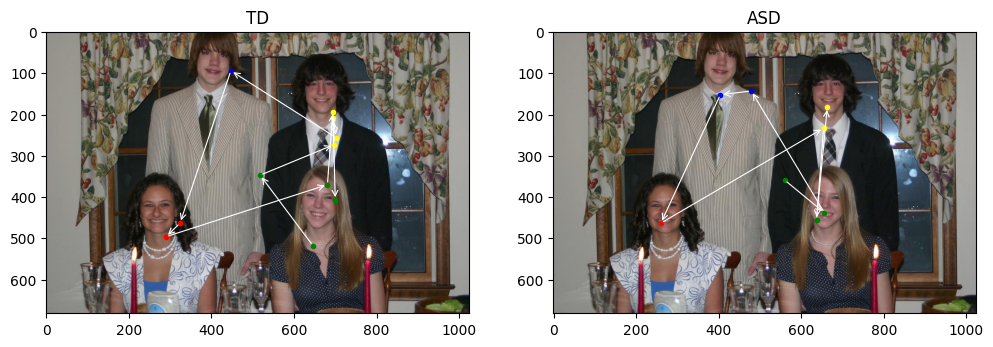

In [77]:
def trace_plot(ax, df: pd.DataFrame, aois: pd.DataFrame, group_colors: bool=True):
    for i in range(len(df.index) - 1):
        ax.annotate(
            "",
            xy=(df["x"][i + 1], df["y"][i + 1]),
            xytext=(df["x"][i], df["y"][i]),
            arrowprops=dict(arrowstyle="->", color="white", lw=0.8),
        )
    for aoi in range(len(aois)):
        x = df[df["AOI"] == aoi]["x"]
        y = df[df["AOI"] == aoi]["y"]
        color = aois.loc[aoi, "color"] if group_colors else "white"
        ax.scatter(x, y, color=color, marker=".")


fig, ax = plt.subplots(1, 2, figsize=(12, 8))
trace_plot(ax[0], asd_dfs[1], AOIS),
ax[0].imshow(image)
ax[0].set(title="TD")

trace_plot(ax[1], td_dfs[1], AOIS),
ax[1].imshow(image)
ax[1].set(title="ASD")



In [18]:
td_matrices = [GraphUtils.transition_matrix(td_df, aois=AOIS) for td_df in td_dfs]
asd_matrices = [GraphUtils.transition_matrix(asd_df, aois=AOIS) for asd_df in asd_dfs]
td_graphs = [GraphUtils.transition_matrix_to_graph(m) for m in td_matrices]
asd_graphs = [GraphUtils.transition_matrix_to_graph(m) for m in asd_matrices]

13

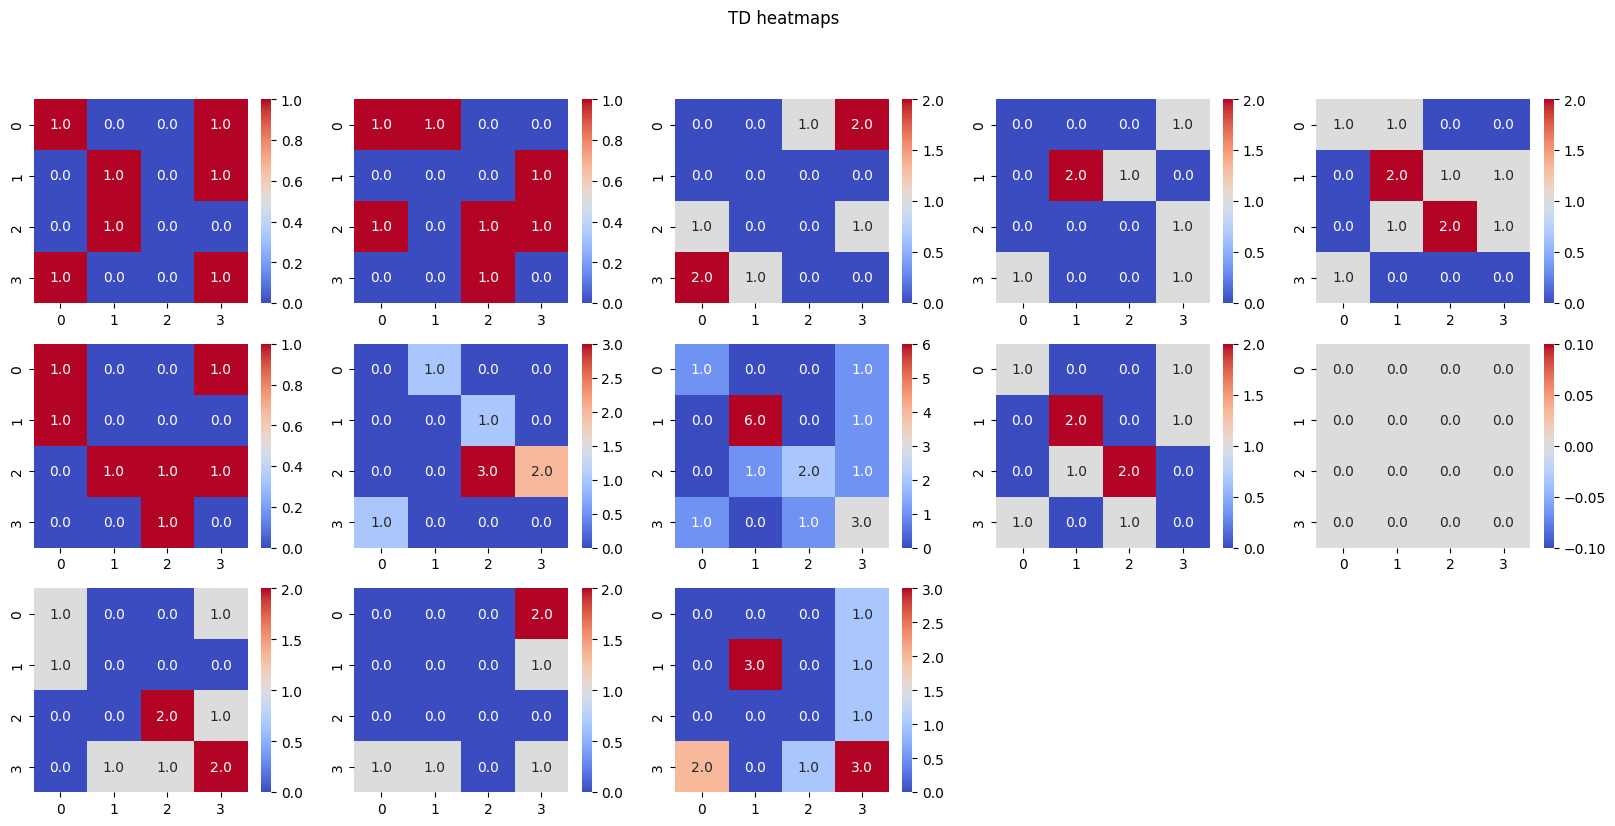

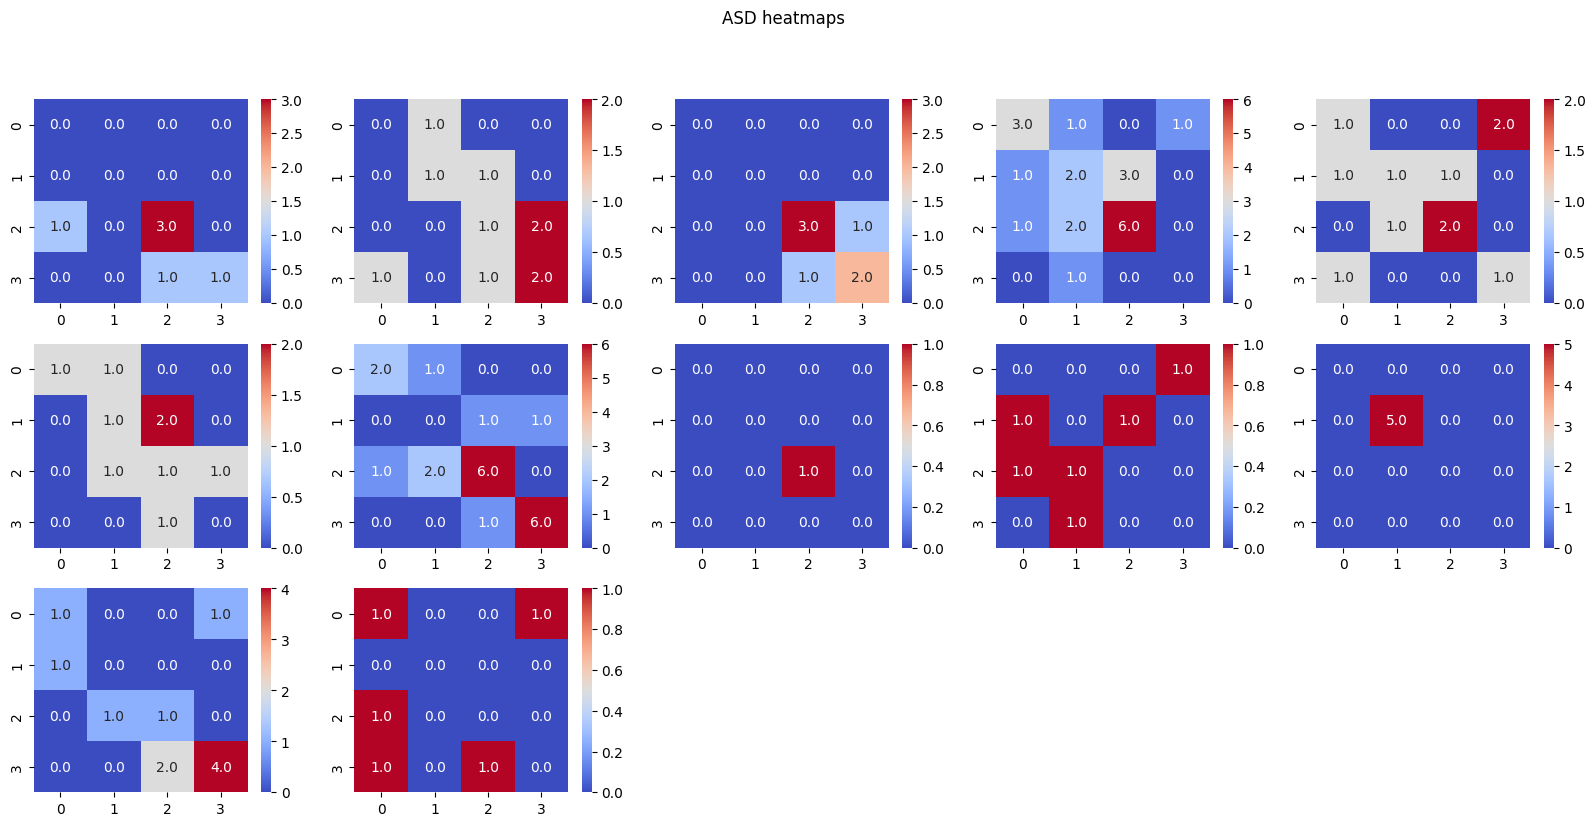

In [40]:
def wrap_subplots(n_plots: int, n_wrap: int):
    ncols = min(n_plots, n_wrap)
    nrows = math.ceil(n_plots / n_wrap)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 3))
    axs = axs.flatten()
    for ax in axs[n_plots:]:
        ax.axis("off")
    return fig, axs


fig, axs = wrap_subplots(len(td_matrices), 5)
fig.suptitle("TD heatmaps")
for i, m in enumerate(td_matrices):
    GraphUtils.heatmap(m, ax=axs[i])


fig, axs = wrap_subplots(len(asd_matrices), 5)
fig.suptitle("ASD heatmaps")
for i, m in enumerate(asd_matrices):
    GraphUtils.heatmap(m, ax=axs[i])

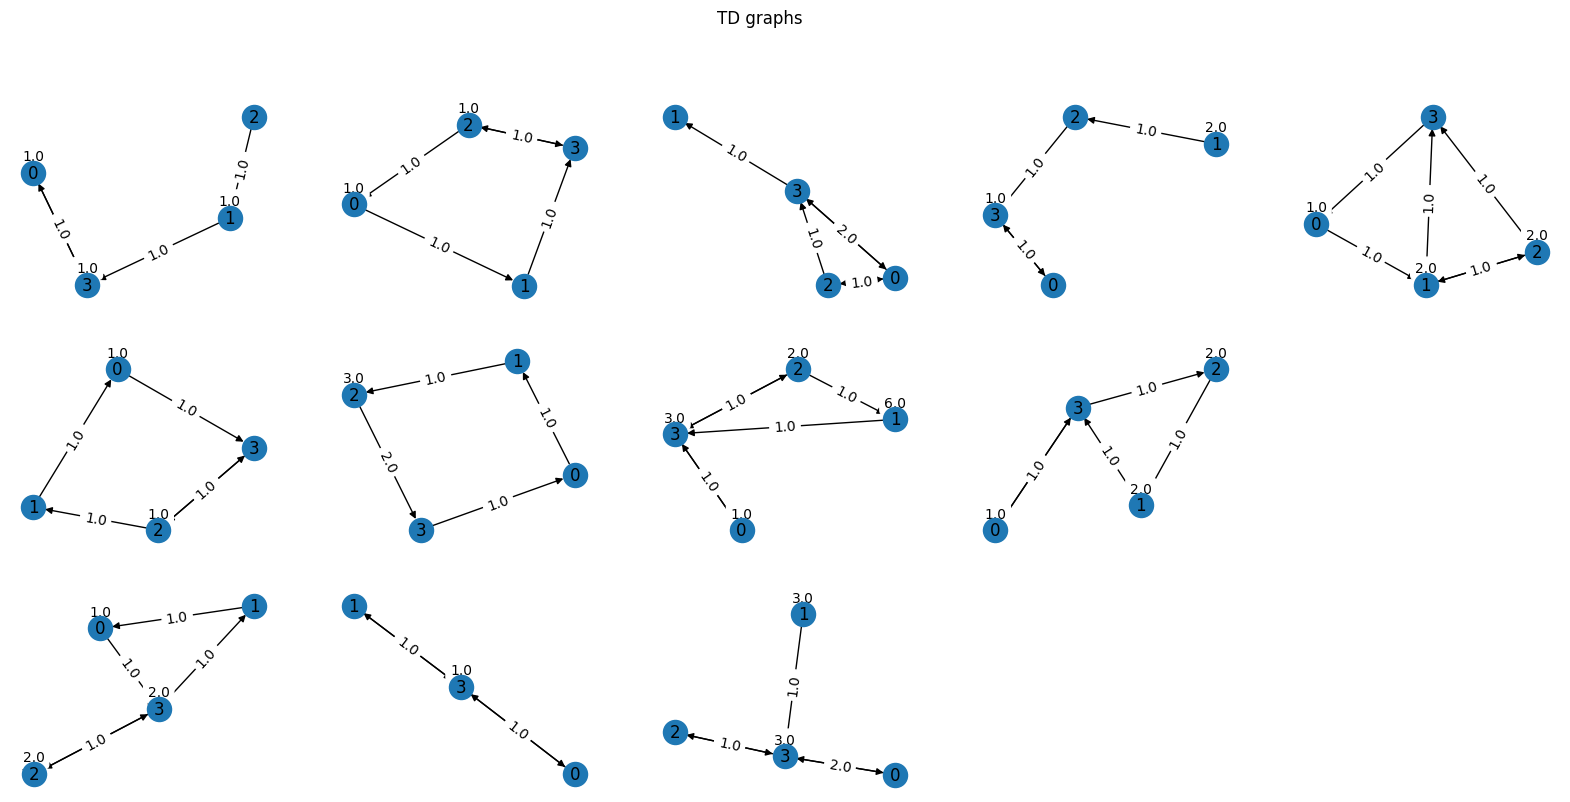

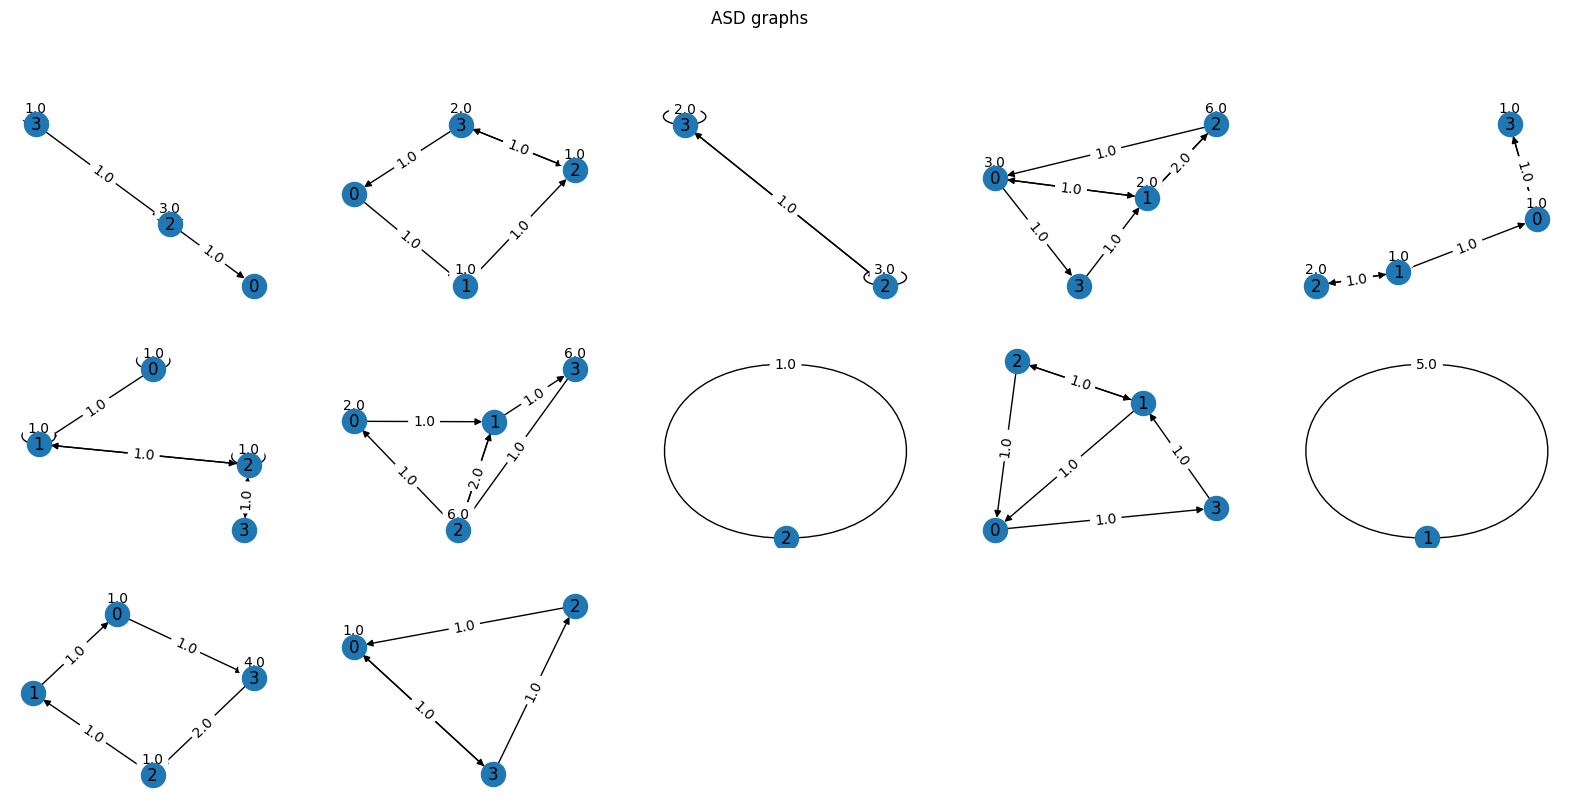

In [43]:
fig, axs = wrap_subplots(len(td_matrices), 5)
fig.suptitle("TD graphs")
for i, g in enumerate(td_graphs):
    GraphUtils.draw(g, weights=True, ax=axs[i])


fig, axs = wrap_subplots(len(asd_matrices), 5)
fig.suptitle("ASD graphs")
for i, g in enumerate(asd_graphs):
    GraphUtils.draw(g, weights=True, ax=axs[i])

## Classification

6


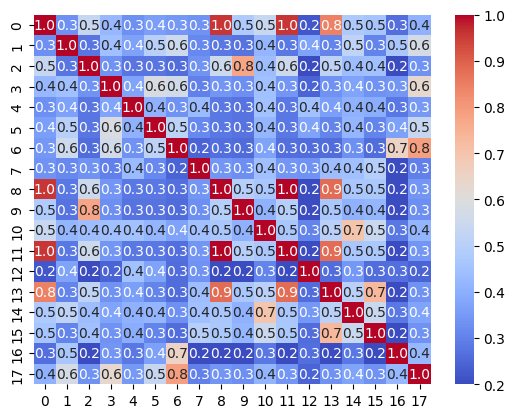

In [66]:
from wl import WL
from labelhasher import LabelHasher

wl = WL(LabelHasher())

TRAIN_SAMPLE_SIZE = 9
TEST_SAMPLE_SIZE = 3
WL_REFINEMENT_STEPS = 4

train_graphs = td_graphs[:TRAIN_SAMPLE_SIZE] + asd_graphs[:TRAIN_SAMPLE_SIZE]
test_graphs = td_graphs[TRAIN_SAMPLE_SIZE:TRAIN_SAMPLE_SIZE+TEST_SAMPLE_SIZE] + asd_graphs[TRAIN_SAMPLE_SIZE:TRAIN_SAMPLE_SIZE+TEST_SAMPLE_SIZE]

train_matrix = np.zeros(shape=(len(train_graphs), len(train_graphs)))
train_labels = np.concatenate([np.zeros(TRAIN_SAMPLE_SIZE), np.ones(TRAIN_SAMPLE_SIZE)])

for i, g1 in enumerate(train_graphs):
    for j, g2 in enumerate(train_graphs):
        v = wl.get_feature_vectors(g1, g2, WL_REFINEMENT_STEPS)
        K = wl.get_kernel_value(v, normalize=True)
        train_matrix[i][j] = K

GraphUtils.heatmap(train_matrix)

In [73]:
svm = SVC(kernel="precomputed")
svm.fit(train_matrix, train_labels)


test_matrix = np.zeros(shape=(2*TEST_SAMPLE_SIZE, 2*TRAIN_SAMPLE_SIZE))
for i, test_graph in enumerate(test_graphs):
    for j, train_graph in enumerate(train_graphs):
        v = wl.get_feature_vectors(test_graph, train_graph, WL_REFINEMENT_STEPS)
        K = wl.get_kernel_value(v, normalize=True)
        test_matrix[i][j] = K
test_labels = np.concatenate([np.zeros(TEST_SAMPLE_SIZE), np.ones(TEST_SAMPLE_SIZE)])


pred_labels = svm.predict(test_matrix)


In [76]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(test_labels, pred_labels)

prec = precision_score(test_labels, pred_labels)

rec = recall_score(test_labels, pred_labels)

f1 = f1_score(test_labels, pred_labels)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 Score:  {f1:.3f}")

Accuracy:  0.500
Precision: 0.500
Recall:    0.333
F1 Score:  0.400
